In [28]:
import configuration as config
import utilities as utils
import DataLoader as dl
import ModelGenerator as mg
import Train
import ModelValidation as mv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import math

In [29]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [30]:
credit_card_data = utils.get_data(config.INPUT_FILE_PATH)

Data loaded from input CSV
Shape of input file:(284807, 31)


In [31]:
no_fraud, fraud = credit_card_data.Class.value_counts()
print(f'No Fraud {no_fraud}')
print(f'Fraud {fraud}')
print(f'Fraud proportion {round(utils.percentage(fraud, no_fraud + fraud), 2)}%')

No Fraud 284315
Fraud 492
Fraud proportion 0.17%


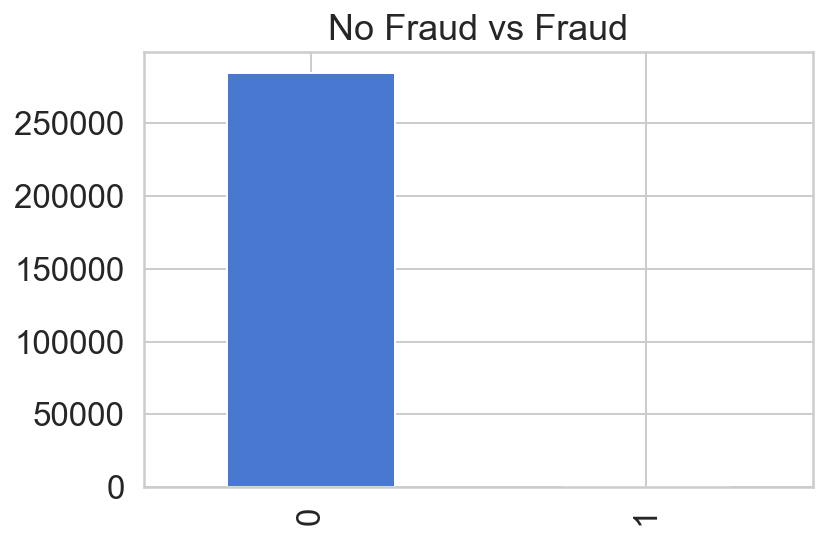

In [32]:
utils.plot_class_balance(credit_card_data, 'Class', title="No Fraud vs Fraud");

In [33]:
data = dl.DataGenerator(credit_card_data, split=0.05)

In [34]:
model = mg.build_model(data.X_train)

In [35]:
history = Train.Trainer(model, data).history

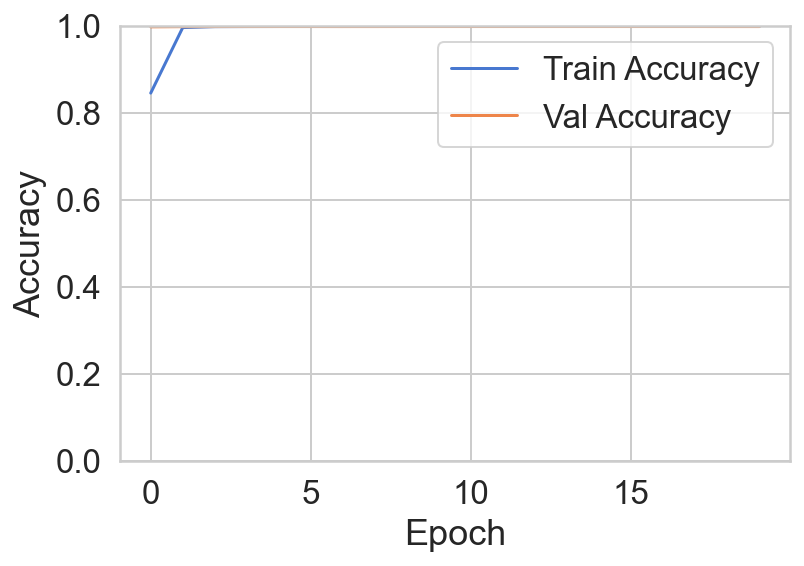

In [36]:
mv.plot_accuracy(history)

In [37]:
model.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE)

14241/14241 [==============================] - 0s 2us/sample - loss: 0.0111 - accuracy: 0.9985


[0.011131953512538886, 0.9985254]

In [38]:
def awesome_model_predict(features):
  return np.full((features.shape[0], ), 0)

In [39]:
y_pred = awesome_model_predict(data.X_test)

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred, data.y_test)

0.9985253844533389

### Model Validation



In [41]:
model_pred = model.predict(data.X_test, batch_size=config.BATCH_SIZE)

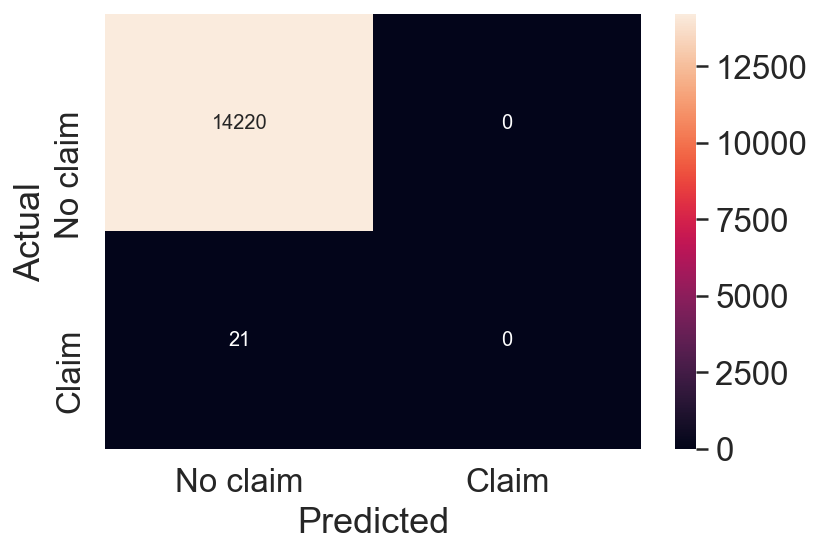

In [42]:
mv.plot_cm(data.y_test, model_pred)

### 1. Trying other metrics to judge the model.

In [43]:
model_metric = mg.build_model(data.X_train, metrics=config.METRICS)

In [44]:
history_metric = Train.Trainer(model_metric, data).history

In [45]:
evaluation_results = model_metric.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_metric.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_metric, evaluation_results, y_pred, data.y_test)

loss :  0.011381775718481845
tp :  0.0
fp :  1.0
tn :  14219.0
fn :  21.0
accuracy :  0.99845517
precision :  0.0
recall :  0.0
auc :  0.49996483
f1 score: 0.0


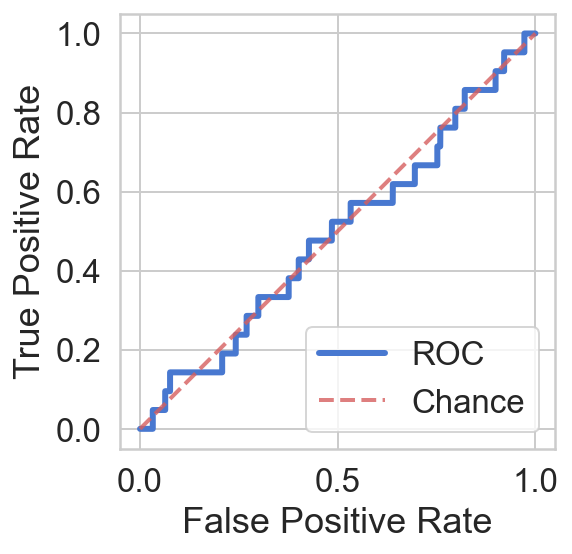

In [46]:
mv.plot_roc(data.y_test, model_pred)

## Clearly base model doesn't do justice to the problem. Even a model predicting all the records as 'No Fraud' will give higher accuracy. This can be seen in precision, recall and F1 score


### Method 1: Weighted Model

In [47]:
no_fraud_count, fraud_count = np.bincount(credit_card_data[config.LABEL_COLUMN])
total_count = len(credit_card_data[config.LABEL_COLUMN])

In [48]:
weight_no_fraud = (1 / no_fraud_count) * (total_count) / 2.0
weight_fraud = (1 / fraud_count) * (total_count) / 2.0

class_weights = {0: weight_no_fraud, 1: weight_fraud}

In [49]:
model_weights = mg.build_model(data.X_train, metrics=config.METRICS)

In [50]:
history_wieghts = Train.Trainer(model_weights,data, class_weights, 1)

In [51]:
model_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)

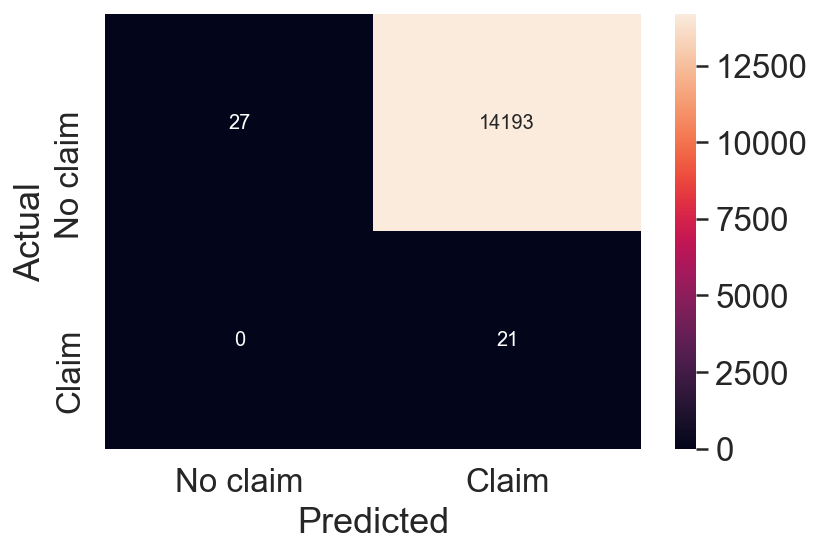

In [52]:
mv.plot_cm(data.y_test, model_pred)

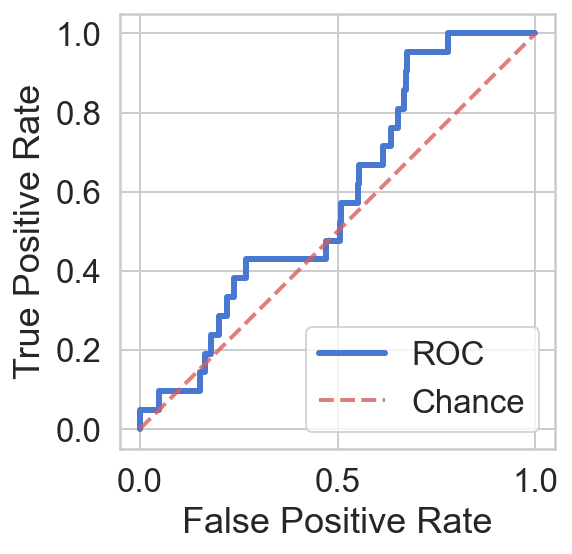

In [53]:
mv.plot_roc(data.y_test, model_pred)

In [54]:
evaluation_results = model_weights.evaluate(data.X_test, data.y_test, batch_size=config.BATCH_SIZE, verbose=0)
y_pred = model_weights.predict(data.X_test, batch_size=config.BATCH_SIZE)
mv.print_metrics(model_weights, evaluation_results, y_pred, data.y_test)

loss :  0.8105887538277946
tp :  21.0
fp :  14193.0
tn :  27.0
fn :  0.0
accuracy :  0.0033705498
precision :  0.0014774166
recall :  1.0
auc :  0.5857511
f1 score: 0.0029504741833508955
